# Setup the imports

In [1]:
import pandas as pd
import os
from datetime import datetime, timezone
import time
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
import fileinput
import shutil

all_data = pd.DataFrame()


## Setup the CSV files

In [2]:
path = os.getcwd()
files = os.listdir(path)
os.makedirs(path + './.temp/', exist_ok=True)
tempDir = path + '/.temp/'
files_xls = [f for f in files if f[-3:] == 'xls']

counter = 0
for file in files_xls: 
    with open(file) as fin, open('./.temp/' + str(counter) + '_New_File.txt', 'w') as fout:
        for line in fin.readlines()[1:]: # don't look at the first line
            fout.write(line.replace('\t', ','))
        counter += 1

## Write the CSVs

In [3]:
tempDir = path + '/.temp/'
tempFiles = os.listdir(tempDir)

files_txt = [f for f in tempFiles if f[-3:] == 'txt']

counter = 0
for file in files_txt: 
    with open(tempDir + file) as fin, open('./.temp/' + str(counter) + '_final.csv', 'w') as fout:
        for line in fin:
            fout.write(line.replace('BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,', 'BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,NothinToSeeHere,'))
        counter += 1

### Append all of the CSVs to one data frame

In [4]:
tempFiles = os.listdir(tempDir)
files_csv = [f for f in tempFiles if f[-3:] == 'csv']

for file in files_csv:
    #print(tempDir + file)
    data = pd.read_csv(tempDir + file)
    all_data = all_data.append(data)

In [5]:
all_data.head()

,Time date,Ticks,Car type,SystemMode,RegulationMode,DI_400_VAC,DI_AIR_FLOW,DI_SPARE_1,DI_CAR_TYPE_0,DI_CAR_TYPE_1,...,BERTH_3_5_FEEDBACK,BERTH_4_FEEDBACK,BERTH_5_2_FEEDBACK,BERTH_6_3_FEEDBACK,BERTH_7_6_FEEDBACK,BERTH_8_FEEDBACK,BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,YoYoMa,Unnamed: 305
0,2020-11-26 03:43:18,34199910,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2020-11-26 03:48:19,34499910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
2,2020-11-26 03:53:19,34799910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
3,2020-11-26 03:55:34,34933825,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
4,2020-11-26 03:55:37,34937115,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN


### Write all of the CSV files to one file

In [5]:
all_data.to_csv("all_data.csv", index=False)
shutil.rmtree(tempDir)

In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2461 entries, 0 to 257
Columns: 306 entries, Time date to Unnamed: 305
dtypes: float64(79), int64(223), object(4)
memory usage: 5.8+ MB


# Import consolidated data into a df

In [4]:
df = pd.read_csv('all_data.csv')

In [9]:
df.head()

,Time date,Ticks,Car type,SystemMode,RegulationMode,DI_400_VAC,DI_AIR_FLOW,DI_SPARE_1,DI_CAR_TYPE_0,DI_CAR_TYPE_1,...,BERTH_3_5_FEEDBACK,BERTH_4_FEEDBACK,BERTH_5_2_FEEDBACK,BERTH_6_3_FEEDBACK,BERTH_7_6_FEEDBACK,BERTH_8_FEEDBACK,BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,YoYoMa,Unnamed: 305
0,2020-11-26 03:43:18,34199910,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2020-11-26 03:48:19,34499910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
2,2020-11-26 03:53:19,34799910,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
3,2020-11-26 03:55:34,34933825,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
4,2020-11-26 03:55:37,34937115,CLUB,MODE_STANDBY,MODE_NOT_IN_REGULATION,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN


#### Sort by date and remove 2006 data

In [5]:
df['Time date'] = pd.to_datetime(df['Time date'])
df = df.sort_values(by='Time date')
df = df.reset_index(drop=True) # Reset the index to line up with the sorted data.
df = df[(df['Time date'].dt.year > 2006)]

In [8]:
df.head()

,Time date,Ticks,Car type,SystemMode,RegulationMode,DI_400_VAC,DI_AIR_FLOW,DI_SPARE_1,DI_CAR_TYPE_0,DI_CAR_TYPE_1,...,BERTH_3_5_FEEDBACK,BERTH_4_FEEDBACK,BERTH_5_2_FEEDBACK,BERTH_6_3_FEEDBACK,BERTH_7_6_FEEDBACK,BERTH_8_FEEDBACK,BERTH_9_FEEDBACK,BERTH_10_FEEDBACK,YoYoMa,Unnamed: 305
135,2020-11-17 18:05:10,107376510,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
136,2020-11-17 18:10:11,107676510,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
137,2020-11-17 18:15:11,107976510,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
138,2020-11-17 18:20:12,108276515,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
139,2020-11-17 18:25:13,108576510,CLUB,MODE_AUTOMATIC,MODE_REGULATION_NORMAL,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN


### Filter out the temperature data for the temperature sensors

In [8]:
temperatureData = pd.DataFrame()

temperatureData['Time date'] = df['Time date']
temperatureData['External Grill Supply'] = df['TEMPERATURE_SUPPLY_1']
temperatureData['SAT1'] = df['TEMPERATURE_SUPPLY_2']
temperatureData['SAT2'] = df['TEMPERATURE_RETURN']
temperatureData['Vestibule E2'] = df['TEMP. VESTIBULE_LEFT']
temperatureData['Vestibule E1'] = df['TEMP. STAFF_WC']
temperatureData['Dining Floor Return'] = df['TEMPERATURE_GUARD_GALLEY_WC']
temperatureData['Guards Rest Room'] = df['TEMP. GUARD_GALLEY_WC']
temperatureData['Guards Control Room'] = df['TEMP. BERTH_1']

temperatureData.to_csv("temperatureData.csv", index=False)

### Filter out the damper data 

In [9]:
dmaperData = pd.DataFrame()
dmaperData['Time date'] = df['Time date']
dmaperData['Fresh Air Damper'] = df['FRESH_DAMPER_FEEDBACK']
dmaperData['Return Air Damper'] = df['RETURN_DAMPER_FEEDBACK']

dmaperData.to_csv("dmaperData.csv", index=False)

In [20]:
temperatureData.tail()

,Time date,External Grill Supply,SAT1,SAT2,Vestibule E2,Vestibule E1,Dining Floor Return,Guards Rest Room,Guards Control Room,Fresh Air Damper,Return Air Damper
130,2020-11-26 12:51:06,15.571,49.681,53.802,18.892,18.081,21.767,18.717,20.099,20.099,18.892
131,2020-11-26 12:53:17,14.773,36.847,39.585,20.425,20.450,22.383,19.485,21.064,21.064,20.425
132,2020-11-26 12:58:18,13.951,34.099,35.596,21.127,21.064,22.692,20.252,21.679,21.679,21.127
133,2020-11-26 13:03:18,12.180,30.583,31.872,21.610,21.262,22.979,20.889,22.273,22.273,21.610
134,2020-11-26 13:08:19,12.720,25.821,26.561,21.786,20.691,22.472,20.911,22.383,22.383,21.786


# Plot the data

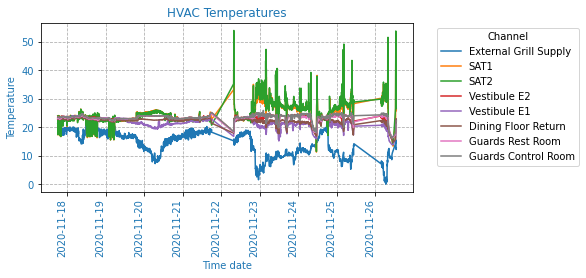

In [10]:
dfTemp = temperatureData[(temperatureData['Time date'].dt.year > 2006)].copy().set_index('Time date')
dfTemp.plot(kind='line', legend=None)
plt.xticks(color='C0', rotation='vertical')
plt.xlabel('Time date', color='C0', size=10)
plt.yticks(color='C0')
plt.tight_layout(pad=2)
plt.title('HVAC Temperatures', color='C0')
plt.ylabel('Temperature', color='C0', size=10)
plt.grid('on', linestyle='--')
lgd = plt.legend(title='Channel', bbox_to_anchor=(1.05, 1))

plt.savefig('myfig100.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', format=None, bbox_extra_artists=(lgd,), bbox_inches='tight',
        transparent=False, pad_inches=0.1)
plt.show()

# Setup the damper data

In [8]:
df = pd.read_csv('all_data.csv')
df['Time date'] = pd.to_datetime(df['Time date'])
df = df.sort_values(by='Time date')
df = df[(df['Time date'].dt.year > 2006)]


damperData = pd.DataFrame()

damperData['Time date'] = df['Time date']
damperData['Fresh Air Damper'] = df['FRESH_DAMPER_FEEDBACK']
damperData['Return Air Damper'] = df['RETURN_DAMPER_FEEDBACK']

damperData.head()

,Time date,Fresh Air Damper,Return Air Damper
135,2020-11-17 18:05:10,23.509,23.659
136,2020-11-17 18:10:11,23.487,23.659
137,2020-11-17 18:15:11,23.531,23.703
138,2020-11-17 18:20:12,23.487,23.659
139,2020-11-17 18:25:13,23.553,23.681


## Overlay the Damper values on the Y2 axis

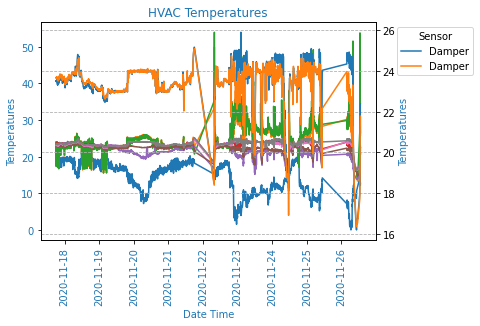

In [34]:
dfTemp = temperatureData.set_index('Time date')
damper = dmaperData.set_index('Time date')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax2.set_ylabel('Temperatures', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(dfTemp, label='Temperature supply')
curve2 = ax2.plot(damper, label='Damper')

lgd = plt.legend(title='Sensor', bbox_to_anchor=(1.05, 1))

plt.title('HVAC Temperatures', color='C0')
plt.grid('on', linestyle='--')

plt.savefig('myfig100.png', dpi=300, facecolor='w', edgecolor='w',
        orientation='landscape', format=None, bbox_extra_artists=(lgd,), bbox_inches='tight',
        transparent=False, pad_inches=0.1)



plt.show()

In [10]:
temperatureData = pd.read_csv("temperatureData.csv")
temperatureData = temperatureData.set_index('Time date')
dmaperData = pd.read_csv("dmaperData.csv")
dmaperData = dmaperData.set_index('Time date')

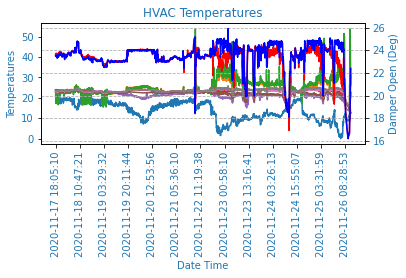

Seconds: 40.968064069747925


In [13]:
start = time.time()
y1 = temperatureData['External Grill Supply']
y2 = temperatureData['SAT1']
y3 = temperatureData['SAT2']
y4 = temperatureData['Vestibule E2']
y5 = temperatureData['Vestibule E1']
y6 = temperatureData['Dining Floor Return']
y7 = temperatureData['Guards Rest Room']
y8 = temperatureData['Guards Control Room']
y9 = temperatureData['Return Air Damper']
y0 = temperatureData['Fresh Air Damper']

x = temperatureData.index


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(x, y1, label='Temperature supply', color='tab:blue')
curve2 = ax1.plot(y2, label='SAT1', color='tab:orange')
curve3 = ax1.plot(y3, label='SAT2', color='tab:green')
curve4 = ax1.plot(y4, label='Vestibule E2', color='tab:red')
curve5 = ax1.plot(y5, label='Vestibule E1', color='tab:purple')
curve6 = ax1.plot(y6, label='Dining Floor Return', color='tab:brown')
curve7 = ax1.plot(y7, label='Guards Rest Room', color='tab:pink')
curve8 = ax1.plot(y8, label='Guards Control Room', color='tab:gray')

ax2.set_ylabel('Damper Open (Deg)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
curve9 = ax2.plot(y9, label='Return Air Damper', color='r')
curve0 = ax2.plot(y0, label='Fresh Air Damper', color='b')

plt.tight_layout(pad=2)
plt.title('HVAC Temperatures', color='C0')
#lgd = plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid('on', linestyle='--')

plt.plot()

ax1.set_xticks(range(0,len(x), 200)) 
plt.show()
print("Seconds: " + str(time.time() - start))

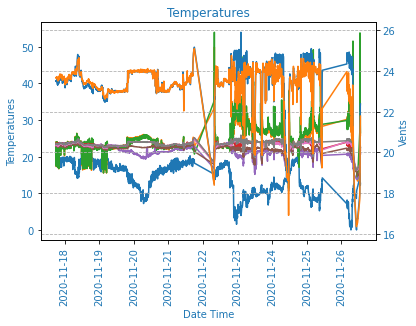

In [37]:
dfTemp = temperatureData.set_index('Time date')
vents = dmaperData.set_index('Time date')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Date Time', color='C0')
ax1.set_ylabel('Temperatures', color='C0')
ax2.set_ylabel('Vents', color='C0')
ax1.tick_params(axis='x', labelcolor='C0', labelrotation=90)
ax1.tick_params(axis='y', labelcolor='C0')
ax2.tick_params(axis='y', labelcolor='C0')

curve1 = ax1.plot(dfTemp, label='Temperature supply')
curve2 = ax2.plot(vents, label='Vents')

plt.title('Temperatures', color='C0')
plt.grid('on', linestyle='--')

plt.show()